Mounting drive and installing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git
!cd pytorch-grad-cam && pip install -e .


Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1240, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 1240 (delta 19), reused 25 (delta 16), pack-reused 1198 (from 1)
Receiving objects: 100% (1240/1240), 137.37 MiB | 23.91 MiB/s, done.
Resolving deltas: 100% (709/709), done.
Obtaining file:///content/pytorch-grad-cam
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for grad-cam (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.2-0.editable-py3-none-any.whl size=9576 sha256=3d4c2471050a61e90084c0875b3ac7c8918e298c32e3c31e4a9092f8e01ed7c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-55bl2iuw/wheels/e8/a3/17/3f39a99ce2c5dd547cf925a92d18d2a67b31877da39af114f0
Successfully built grad-cam


In [ ]:
!pip install efficientnet-pytorch


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=6add4f752cb1daf79315cfc4f4dcba59c07f4c0cd844f6b28e066a68b832dd84
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
import sys
sys.path.append('/content/pytorch-grad-cam')

Importing necessary libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from efficientnet_pytorch import EfficientNet
from pytorch_grad_cam import GradCAM
import matplotlib.pyplot as plt
import torch.nn.functional as F
from glob import glob

Data loading class to match the image with it's mask

In [ ]:
class SkinCancerDataset(Dataset):
    def __init__(self, images_folder, masks_folder, oneshot_image_path=None, oneshot_mask_path=None, transform=None, mask_transform=None):
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_paths = sorted(glob(os.path.join(images_folder, '*.[jp][pn]g')))
        self.mask_paths = sorted(glob(os.path.join(masks_folder, '*.[jp][pn]g')))

        if oneshot_image_path and oneshot_mask_path:
            self.oneshot_image = Image.open(oneshot_image_path).convert('RGB')
            self.oneshot_mask = Image.open(oneshot_mask_path).convert('L')

            if self.transform:
                self.oneshot_image = self.transform(self.oneshot_image)
            if self.mask_transform:
                self.oneshot_mask = self.mask_transform(self.oneshot_mask)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

Data loading and preprocessing

In [ ]:
train_images_folder = '/content/drive/My Drive/data/ISBI2016_ISIC_Part1_Training_Data/'
train_masks_folder = '/content/drive/My Drive/data/ISBI2016_ISIC_Part1_Training_GroundTruth/'
oneshot_image_path = '/content/drive/My Drive/data/oneshot_image.png'
oneshot_mask_path = '/content/drive/My Drive/data/oneshot_mask.png'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = SkinCancerDataset(
    images_folder=train_images_folder,
    masks_folder=train_masks_folder,
    oneshot_image_path=oneshot_image_path,
    oneshot_mask_path=oneshot_mask_path,
    transform=transform,
    mask_transform=mask_transform
)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

Transfer learning: Using EfficientNet

In [ ]:
class EfficientNetSegmentation(nn.Module):
    def __init__(self, backbone):
        super(EfficientNetSegmentation, self).__init__()
        self.backbone = backbone
        self.backbone._fc = nn.Identity()

        self.conv1 = nn.Conv2d(in_channels=self.backbone._conv_head.out_channels, out_channels=512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1)
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.backbone.extract_features(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.upsample(x)
        x = torch.sigmoid(x)
        return x

backbone = EfficientNet.from_pretrained('efficientnet-b0')

Training the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetSegmentation(backbone).to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.BCELoss()

epochs = 10
model.train()

for epoch in range(epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 139MB/s]


Loaded pretrained weights for efficientnet-b0
Epoch [1/10], Loss: 0.6220953608381337
Epoch [2/10], Loss: 0.5803612141773619
Epoch [3/10], Loss: 0.569063702533985
Epoch [4/10], Loss: 0.5664050435197765
Epoch [5/10], Loss: 0.5641300842679781
Epoch [6/10], Loss: 0.5626570705709786
Epoch [7/10], Loss: 0.5620766035441694
Epoch [8/10], Loss: 0.5604376628481108
Epoch [9/10], Loss: 0.5599646095571846
Epoch [10/10], Loss: 0.559738697676823


GradCAM visualization

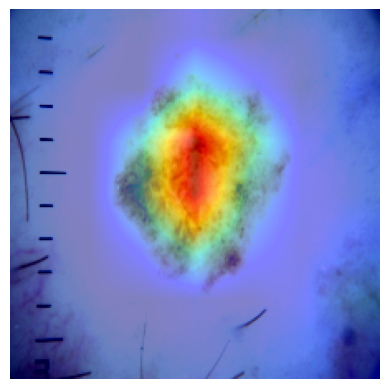

In [ ]:
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

target_layer = [model.backbone._blocks[-1]]
cam = GradCAM(model=model, target_layers=target_layer)

def visualize_cam(image, cam, target_mask):
    target_mask_np = target_mask.cpu().numpy()
    targets = [SemanticSegmentationTarget(0, target_mask_np)]
    grayscale_cam = cam(input_tensor=image.unsqueeze(0), targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.imshow(grayscale_cam, alpha=0.5, cmap='jet')
    plt.axis('off')
    plt.show()

sample_image, sample_mask = next(iter(train_loader))

visualize_cam(sample_image[0], cam, sample_mask[0])

Manual testing

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 15.4MB/s]


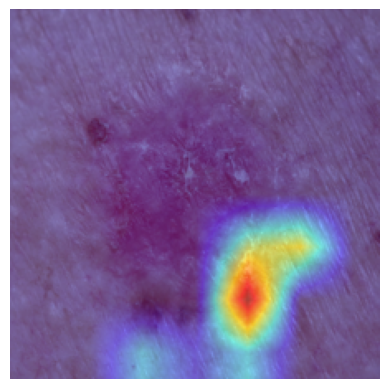

In [ ]:
from google.colab import drive
from PIL import Image
import torch
from torchvision import transforms, models
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

drive.mount('/content/drive')

img_path = '/content/drive/My Drive/data/oneshot_image.png'
image = Image.open(img_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0)

model = models.efficientnet_b0(pretrained=True)
model.eval()

target_layer = model.features[-1]
cam = GradCAM(model=model, target_layers=[target_layer])

targets = [ClassifierOutputTarget(0)]
grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

img_np = image_tensor.squeeze(0).permute(1, 2, 0).numpy()
img_np = img_np - img_np.min()
img_np = img_np / img_np.max()

cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(cam_image)
plt.axis('off')

cam_output_path = '/content/drive/My Drive/data/grad_cam_output.png'
Image.fromarray(cam_image).save(cam_output_path)
